# CW16 - GP
Discard: Trying to do GP regression with base points, not very successful

In [147]:
# Makes it easier to debug
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [148]:
import numpy as np
import pylab as plt
from scipy.linalg import inv
from scipy import stats
import scipy
import torch

In [149]:
import dynesty
import swyft

## Model

In [150]:
NBINS = 30  # Number of data bins
freqs = np.fft.rfftfreq(NBINS)
NFBINS = len(freqs)
NPAR = 2*NFBINS + 2  # Number of model parameters, including two hyper-parameters
SIGMA = 0.000000001  # Measurement uncertainty

In [151]:
def model(v):
    a = v[:NFBINS*2]  # amplitudes
    a = a[:NFBINS] + a[NFBINS:]*1j  # complex amplitudes
    slope, norm = v[-2:]  # spectral index and normalization
    f = np.fft.rfftfreq(NBINS)
    a *= (1+f/f[1])**(-slope)
    x = np.fft.irfft(a)
    x /= x.std()*norm
    return dict(x = x)

In [152]:
# Noise model
def noise(sim, v):
    noise = np.random.randn(NBINS)*SIGMA
    return dict(x = sim['x'] + noise)

In [153]:
def transform(u):
    v = np.zeros_like(u)
    v[:-2] = scipy.stats.norm(0., 1.).ppf(u[:-2]*0.99999 + 0.000005)  # real-valued amplitudes
    v[-2] = u[-2]*.1 + 1.  # slope
    v[-1] = u[-1]*0.1+0.9  # norm
    return v

[1.04230028 0.99634361]


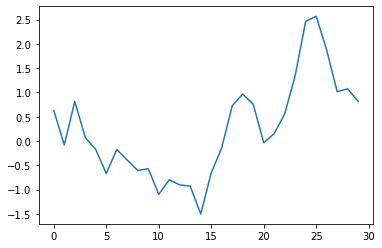

In [156]:
u0 = np.random.rand(NPAR)
v0 = transform(u0)
print(v0[-2:])
obs0 = noise(model(v0), v0)
plt.plot(obs0['x'])
#print(v0.shape)
#print(obs0['x'].shape)

In [157]:
from swyft.networks.module import Module
from typing import Sequence
from swyft.networks.tail import _get_z_shape, _combine
from swyft.networks.normalization import OnlineNormalizationLayer
from swyft.networks.linear import LinearWithChannel
from torch import nn
from swyft.types import ObsType, SimShapeType

In [158]:
class NewTail(swyft.Module):
    def __init__(
        self,
        n_features: int,
        marginals,
        hidden_layers: Sequence[int] = [256, 256, 256],
        p: float = 0.0,
        online_norm: bool = True,
        param_transform=None,
        tail_features: bool = False,
        n_tail_features: int = 2,
    ):
        """Default tail network.

        Args:
            n_features: Length of feature vector.
            marginals: List of marginals to learn.
            hidden_layers: Hidden layer size
            p: Dropout
            online_norm: Online normalization of parameters.
            param_transform: Perform optional parameter transform.
            tail_features: Use tail features.
            n_tail_features: Additional feature extractor network, number of features.

        .. note::
            We find that the default settings for the tail network typically
            give reasonable results, and are almost always enough.  Tuning
            makes only sense when the head network is already close-to optimal.
        """
        super().__init__(
            n_features,
            marginals,
            n_tail_features=n_tail_features,
            p=p,
            hidden_layers=hidden_layers,
            online_norm=online_norm,
            param_transform=param_transform,
            tail_features=tail_features,
        )
        
        NH = 1024
       
        self.logA = nn.Parameter(torch.zeros(NPAR))
        self.S = nn.Parameter(torch.zeros(NPAR))
        self.l1 = nn.Linear(2*NFBINS, NH)
        self.l2 = nn.Linear(NH, NH)
        self.l3 = nn.Linear(NH, NPAR)
        self.ac = nn.ReLU()
        #self.a = nn.Parameter(torch.ones(N))
        #self.b = nn.Parameter(torch.zeros(N))

    def forward(self, f: torch.Tensor, params) -> torch.Tensor:  # TODO Christoph typing
        """Forward pass tail network.  Can handle one batch dimension.

        Args:
            f (tensor): feature vectors with shape (n_batch, n_features)
            params (dict): parameter dictionary, with parameter shape (n_batch,)

        Returns:
            lnL (tensor): lnL ratio with shape (n_batch, len(marginals))
        """
       # print(f.shape)
       # print(params.shape)
        #params = params[:,:N]
        A = torch.exp(self.logA)
        #print(f.shape)
        #print(f.shape, params.shape)
        f = torch.fft.rfft(f)
        f = torch.view_as_real(f).reshape(-1, 2*NFBINS)
        #print(f.shape)
        #print(f)
        f = self.l1(f)
        f = self.ac(f)
        f = self.l2(f)
        f = self.ac(f)
        f = self.l3(f)
        r = -A*(f - params)**2 - self.S
        return r

        # Feature compressors independent per channel
        #print(f.shape)
        f = f.unsqueeze(1).repeat(
            1, self.n_channels, 1
        )  # (n_batch, n_channels, n_features)
        #print(f.shape)
        
        # Channeled density estimator
        #print(params.shape)
        z = _combine(params, self.marginals)
        #print(z.shape)
        z = self.onl_z(z)

        x = torch.cat([f, z], -1)
        x = self.ratio_estimator(x)
        x = x.squeeze(-1)
        print(x)
        
        return x

In [159]:
sim = swyft.Simulator(model, NPAR, dict(x=(NBINS,)))
prior = swyft.Prior(lambda u: transform(u), NPAR, n = 1000)

In [160]:
class ZoomTask:
    def __init__(self, sim_or_store, prior, target_obs, partition = None, simhook = None, init_bound = None):
        if not isinstance(sim_or_store, swyft.Simulator):
            self.store = sim_or_store
        else:
            self.store = swyft.MemoryStore(sim)
        
        if partition is None:
            self.partition = list(range(len(self.store.pnames)))
        else:
            self.partition = partition
            
        self.prior = prior
        self.simhook = simhook
        self.target_obs = target_obs
        
        self.init_bound = init_bound
        self.last_bound = None
        self.history = []
        
    def run(self, rounds = 10, N = 10000, train_args = {}, head = None, tail = None):
        for i in range(rounds):
            self.round(N = N, train_args = train_args, head = head, tail = tail)
        
    def round(self, N, train_args = {}, head = None, tail = None):
        bound = self.init_bound if self.history == [] else self.history[-1][1]
        
        self.store.add(N, self.prior, bound = bound)
        self.store.simulate()
        dataset = swyft.Dataset(N, self.prior, self.store, simhook = self.simhook, bound = bound)
        post = swyft.Posteriors(dataset)
        post.add(self.partition, device='cuda', head = head, tail = tail, tail_args = dict(p=0.2, hidden_layers = [512, 512]))
        post.train(self.partition, **train_args)
        bound = post.truncate(self.partition, self.target_obs)
        
        self.history.append([post, bound])

In [161]:
%%time
task = ZoomTask(sim, prior, obs0, simhook = noise, partition = [[i] for i in range(NPAR)])
task.run(rounds = 2, N = 10000, train_args = dict(batch_size = 64, max_epochs = 40), tail = NewTail, head = swyft.DefaultHead)

Creating new store.
Store: Adding 10032 new samples to simulator store.
Training: lr=0.001, Epoch=40, VL=31.72, TL=24.13
Bounds: Truncating...
Bounds: ...done. New volue is V=7.446e-06
Store: Adding 10010 new samples to simulator store.
Training: lr=0.001, Epoch=40, VL=29.36, TL=25.38
Bounds: Truncating...
Bounds: ...done. New volue is V=3.215e-10
CPU times: user 2min 56s, sys: 26.3 s, total: 3min 22s
Wall time: 4min 57s


In [164]:
task.run(rounds = 2, N = 10000, train_args = dict(batch_size = 64, max_epochs = 40), tail = NewTail, head = swyft.DefaultHead)

Training: lr=0.001, Epoch=40, VL=30.78, TL=27.29
Bounds: Truncating...
Bounds: ...done. New volue is V=5.468e-13
Store: Adding 9966 new samples to simulator store.
Training: lr=0.001, Epoch=40, VL=31.16, TL=27.71
Bounds: Truncating...
Bounds: ...done. New volue is V=6.381e-15


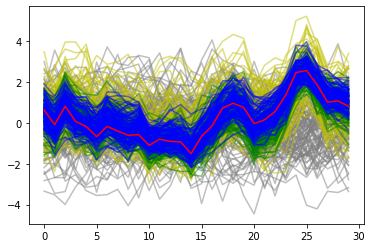

In [165]:
for h, c in zip(task.history[-4:], ['0.5', 'y', 'g', 'b']):
    ds = h[0].dataset
    for i in range(100):
        plt.plot(ds[i][0]['x'], color=c, alpha = 0.5)
plt.plot(obs0['x'], 'r')

In [166]:
samples = task.history[-1][0].sample(100000, obs0)

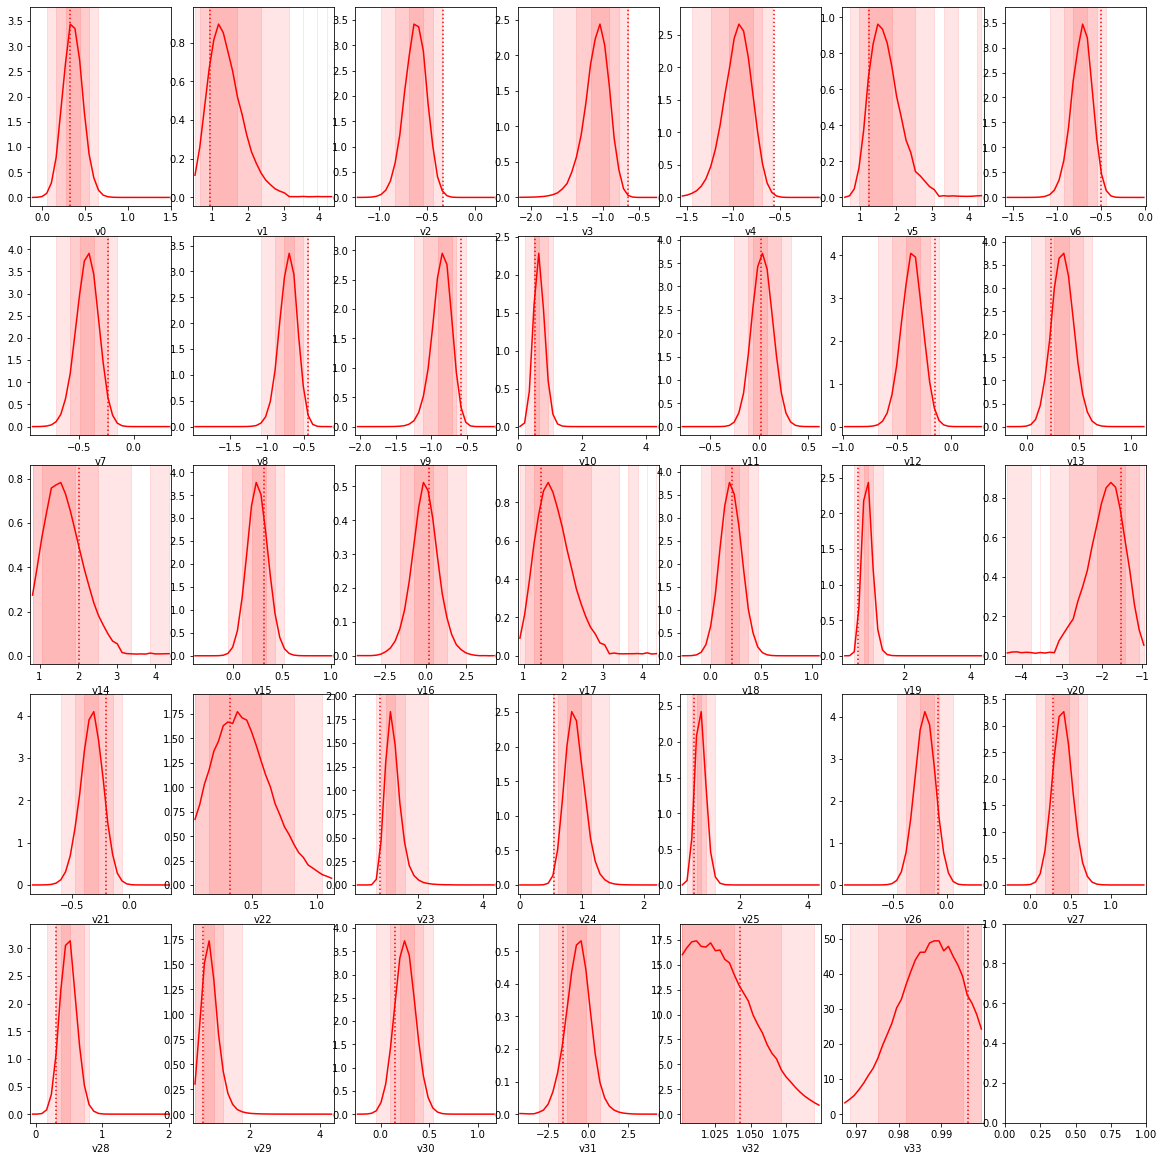

In [167]:
fig, diag = swyft.plot_1d(samples, range(NPAR), bins = 30, figsize=(20, 20), truth = v0, color='r', contours = True, ncol = 7)